In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random
from collections import defaultdict
import math as math

In [33]:
def generate_scenario(n, S, T):
    #S scenarios in second stage, T in extended stage
    scenario = []
    pT=np.random.rand(S,T)
    pT=pT/sum(sum(pT))
    pT=pT.tolist()
    for i in range(n):
        x=[]
        for j in range(S):
            xS=random.uniform(0,0.6)
            x1=[]
            for k in range(T):
                xT=random.uniform(0,1)
                x2=[xS,xT,pT[j][k]]
                x1.append(x2)
            x.append(x1)
        scenario.append(x)
    return scenario 
    #n*S*T*3 list, each element is [\xi_2,\xi_1,p]
    #for example, sum(scenario[0][0][:][2]) is probability for S=0. 
    #             scenario[0][0][0][2]/sum(scenario[0][0][:][2]) is probability for T=0|S=0. 
    #             scenario[i] is scenario for agent i
    
    
#this part is working fine.
scenario = generate_scenario(3,3,3)
#scenario, [[scenario[i][0][j][1] for j in range(3)] for i in range(3) ]
#scenario, [scenario[i][0][j][2]/sum(scenario[i][0][k][2] for k in range(3)) for j in range(3)]

In [8]:
import pickle
with open('data', 'rb') as handle:
    meta_parameter = pickle.load(handle)
    scenario_b = pickle.load(handle)

def generate_scenario_from_MS(meta_parameter, scenario_b):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    #S scenarios in second stage, T in extended stage
    scenario = []

    for i in range(n):
        x=[]
        for j in range(S):
            xS=scenario_b[j]['xi_1'][i]
            x1=[]
            for k in range(T):
                xT= scenario_b[j][k]['xi_2'][i]
                x2=[xS,xT,scenario_b[j][k]['prob']]
                x1.append(x2)
            x.append(x1)
        scenario.append(x)
    return n,K,S,T,scenario
n,K,S,T,scenario = generate_scenario_from_MS(meta_parameter, scenario_b)

In [4]:
#scn = [ sum(sum((scenario[i][s][t][0] + (1-scenario[i][s][t][0])*scenario[i][s][t][1])*scenario[i][s][t][2]/sum(scenario[i][s][t][2] for t in range(3)) for t in range(3)) for i in range(3)) for s in range(3)]
#scn = [ [sum(scenario[i][s][t][0] + (1-scenario[i][s][t][0])*scenario[i][s][t][1] for i in range(3)) for t in range(3)] for s in range(3)]
scenario
#scn, [sum(scenario[0][s][t][2] for t in range(3)) for s in range(3)]
#scenario[1][0][0][0]+(1-scenario[1][0][0][0])*scenario[1][0][0][1]

[[[[0.15333352650716905, 0.032728971142412244, 0.03521698293523168],
   [0.15333352650716905, 0.5555600610222816, 0.030164106274881787],
   [0.15333352650716905, 0.36153826743542883, 0.006789578687050991],
   [0.15333352650716905, 0.10921002345296849, 0.023995287543519015],
   [0.15333352650716905, 0.2020261655304636, 0.0321285806542231],
   [0.15333352650716905, 0.36186424494721603, 0.02698801835758034],
   [0.15333352650716905, 0.40194568802245223, 0.019891562898113193],
   [0.15333352650716905, 0.7444063757735375, 0.012265325138393604],
   [0.15333352650716905, 0.10078824120418972, 0.0023584765978963895],
   [0.15333352650716905, 0.5077778691767812, 0.018435827916891395]],
  [[0.423852003095939, 0.880849335521128, 0.02682729836951285],
   [0.423852003095939, 0.12048283658458614, 0.025299775490345514],
   [0.423852003095939, 0.6087864719523763, 0.019346307598209586],
   [0.423852003095939, 0.7458870770819561, 0.007115208701974262],
   [0.423852003095939, 0.31940706861198676, 0.005242

In [4]:
def evaluation(x, alpha):
    if (x<=alpha/2):
        return 4*((x/alpha) - (x/alpha)**2)
    else:
        return 1

#evaluation function f(x) = min(1, g(x))
#g(x) = (4/alpha^2)*(alpha*x - x^2), alpha = K/(n-1)

Solve for benchmark without order constraint

In [36]:
def subproblem_b(x, s, scenario, K, output_yz):
    
    #x is a 1*n vector, decision variable for 1st stage
    #s is the s_st scenario we currently want to solve
    #scenario is the S*T*3 matrix we generated before
    #K is total resources allowed that decides evaluation function
    
    #if output_yz==1, then return y. if ==2, return z. used for construct benchmark variable
    
    n=len(x)
    T=len(scenario[0][0])
    alpha=2*K
    
    sp = gp.Model("subproblem")
    
    #w = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="w", lb=list(np.zeros(n)))
    w = [evaluation(scenario[i][s][0][0]*x[i], alpha) for i in range(n)]
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    
    scenario_extended = [[scenario[i][s][j][1]*(1-scenario[i][s][j][0]) for j in range(T)]  for i in range(n)]
    #n*T list, [i,j] is r_i(\xi^{s,j})
    prob_extended_list = [scenario[0][s][j][2]/sum(scenario[0][s][k][2] for k in range(T)) for j in range(T)]
    prob_extended = dict([(t,prob_extended_list[t]) for t in range(T)])
    #conditional probability of extended stage, conditioned by scenario s at second stage

    extended_obj     = sp.addVars(n,T,vtype=GRB.CONTINUOUS, name="extended_obj", lb=list(np.zeros((n,T))))
    extended_obj_sum = sp.addVars(T,vtype=GRB.CONTINUOUS, name="extended_obj_sum")
    extended_obj_exp = sp.addVar(vtype=GRB.CONTINUOUS, name="extended_obj_exp")

    reallo_cost = 0.01

    sp.setObjective( sum(w) - reallo_cost*z.sum() + extended_obj_exp, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate')
    
    extended_val = [[4 * ((scenario_extended[i][t]*y[i]/alpha) - (scenario_extended[i][t]*scenario_extended[i][t]*y[i]*y[i]/(alpha*alpha))) for i in range(n)] for t in range(T)]
    extended_ub_evaluation = sp.addConstrs( (extended_obj[i,t] <= 4 * ((scenario_extended[i][t]*y[i]/alpha) - (scenario_extended[i][t]*scenario_extended[i][t]*y[i]*y[i]/(alpha*alpha))) for i in range(n) for t in range(T)), name = 'extended_ub_evaluation' )
    extended_sum = sp.addConstrs( (extended_obj_sum[t] == extended_obj.sum('*',t) for t in range(T)), name = 'extended_sum')
    extended_exp = sp.addConstr( (extended_obj_exp == extended_obj_sum.prod(prob_extended)), name = 'extended_exp')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    
    sp.optimize()

    if sp.status == GRB.OPTIMAL:
        feas = 1
        
        cut_val = sp.ObjVal
        
        lmbd = [reallocate[i].Pi for i in range(n)]
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + 4*(1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]
        print(cut_val, cut_subdiff)       
        if output_yz==0:
            return cut_val, cut_subdiff, feas
        elif output_yz==1:
            return [y[i].x for i in range(n)]
        elif output_yz==2:
            return [[z[i,j].x for i in range(n)] for j in range(n)]
    
    else:    
        print("infeasible", sp.status)

In [17]:
def masterproblem_b(x_start, n, K, scenario):
    
    max_it = 1e4
    S = len(scenario[0])
    T = len(scenario[0][0])
    prob_s = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp = gp.Model("masterproblem")
    
    x = mp.addVars(n,   vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S,   vtype=GRB.CONTINUOUS, name="v")
    
    mp.setObjective(v.prod(prob_s_dict), GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_current_iter = x_start #n*1 vector
    
    while (it<max_it):
        
        stop_crit = 0
        optm_sec_stage = list(np.zeros(S))
        
        for s in range(S):
        
            (val, subdiff, feas) = subproblem_b(x_current_iter, s, scenario, K, 0)
        
            if feas==1:
                subdiff = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( v[s] <= val + x.prod(subdiff) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) )
                
                optm_sec_stage[s] = val
        
        mp.optimize()
        
        for i in range(n):
            x_current_iter[i] = x[i].x
        
        for s in range(S):
            stop_crit += abs(optm_sec_stage[s]-v[s].X)
        
        if ( stop_crit < 1e-5 ):
            break;
            
        it = it + 1
    
    print(it)
    
    return [v[s].x for s in range(S)], [x[i].x for i in range(n)]
        

In [34]:
n = 3; #number of agents
K = 2; #maximum resources stored
S = 3;
T = 3;
scenario = generate_scenario(n,S,T)
alpha = 2*K;
reallo_cost=0.01
(v_rn,x_rn) = masterproblem_b([1 for i in range(n)], n, K, scenario)
y_rn = [subproblem_b(x_rn, s, scenario, K, 1) for s in range(S)]
z_rn = [subproblem_b(x_rn, s, scenario, K, 2) for s in range(S)]
w_rn = [ [sum(evaluation(x_rn[i]*scenario[i][s][0][0], alpha) for i in range(n))-reallo_cost*sum([sum(z_rn[s][i]) for i in range(n)])+sum(evaluation(y_rn[s][i]*scenario[i][s][t][1]*(1-scenario[i][s][0][0]), alpha) for i in range(n)) for t in range(T)] for s in range(S)]
#w_rn is a S*T matrix

#so benchmark at second stage scenario s is w_rn[s], with p=scenario[0][0][t][2]/sum(scenairo[0][0][t][2] for t in range(T))
#bench mark at first stage is v_rn

val [[0.13623407378266653, 2.9886946515940207e-07, 0.7866214481352569], [0.32864637108525085, 9.401778392461134e-08, 0.8605877533366945], [0.45231977613228513, 1.3385101157787917e-06, 0.037565583853901935]]
obj [[0.1362340450211363, 2.9708212734914883e-07, 0.7866212130932709], [0.3286463685134656, 9.08743121501216e-08, 0.8605877378606225], [0.4523197613979753, 1.3076824083405758e-06, 0.037565573694576165]]
val [[0.002837593722664906, 1.6134475123018152e-08, 0.8694939371895559], [0.0036331983436394865, 5.626762756534568e-07, 0.35029530485573984], [0.02277864983537125, 5.702136657047377e-07, 0.7228747933422996]]
obj [[0.002837553655114373, 5.844826509945242e-09, 0.8694933839035875], [0.00363318205560697, 7.004629954783619e-07, 0.3502952946687879], [0.02277866572802903, 7.083410571542394e-07, 0.7228747695929251]]
val [[1.3812692666584179e-06, 0.5937618450207574, 6.8462067091329105e-09], [3.2272576542590387e-06, 0.4601550150048902, 6.157266368007123e-08], [6.777697972169205e-06, 0.37667468

In [37]:
with open('data', 'rb') as handle:
    meta_parameter = pickle.load(handle)
    scenario_b = pickle.load(handle)
n,K,S,T,scenario = generate_scenario_from_MS(meta_parameter, scenario_b)
alpha = 2*K
reallo_cost=0.01
(v_rn,x_rn) = masterproblem_b([1 for i in range(n)], n, K, scenario)
print(x_rn)
print(v_rn)

1.48738852084927 [0.3151735480731122, 0.5213265339062851, 0.4631699361444357]
1.5877819066973977 [0.24242836434192236, 0.5010255260170298, 0.48373317105180696]
1.6918070382702202 [0.506473250705623, 0.5160355466449171, 0.446386524206624]
1.1022792404728468 [0.37294743765376315, 0.41069878356686645, 0.554944163636626]
1.1614120818070275 [0.3635417948763476, 0.3785389519748138, 0.6800199410910024]
1.1364389970012758 [0.6041694061606376, 0.4319238538161777, 0.5061835386948812]
1.1538739363399055 [0.3646256382345089, 0.49203594502172493, 0.5106544500410206]
1.2889448688938256 [0.35605553484131014, 0.48526576799890875, 0.5892580288941017]
1.1538214466503787 [0.6006205578772175, 0.4932859266057207, 0.47802158150655955]
1.1375935323992281 [0.3591810701879505, 0.5580182474432066, 0.4782246954732994]
1.3014974808667532 [0.3499327615964425, 0.5725337116167828, 0.5170405971929813]
1.1278620328514188 [0.5981637590281061, 0.5438349728740599, 0.45876937512015437]
1.1519919148903535 [0.36102947246394

In [ ]:
w_rn, v_rn, x_rn

([[1.2547033320099235, 0.836928517307111, 1.1093687961047043],
  [1.0442331046198567, 1.1296412975826424, 1.142914264066035],
  [1.3863944446521899, 1.338723724007612, 1.1198915251520711]],
 [1.0816067157395097, 1.1088045661797277, 1.281707430647004],
 [0.0, 2.3921771445090054, 2.6078228554909946])

if using a simple benchmark

In [ ]:
w_bm = [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]
v_bm = [sum(w_bm[s][t]*scenario[0][s][t][2] for t in range(T))/sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]

Solving the problem with stochastic dominant constraints

In [ ]:
def subproblem(x, s, scenario, K, w_bm):
    
    n=len(x)
    T=len(scenario[0][0])
    alpha=2*K
    reallo_cost = 0.01
    
    sp = gp.Model("subproblem")
    
    w = [evaluation(scenario[i][s][0][0]*x[i], alpha) for i in range(n)]
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    
    shift = sp.addVar(vtype=GRB.CONTINUOUS, name="shift", lb=-GRB.INFINITY)
    
    obj_determined = sp.addVar(vtype=GRB.CONTINUOUS, name="obj_determined", lb=-GRB.INFINITY)
    obj_det = sp.addConstr( obj_determined == sum(w)    , name='obj_det' )
    
    scenario_extended = [[scenario[i][s][j][1]*(1-scenario[i][s][j][0]) for j in range(T)]  for i in range(n)]
    #n*T list, [i,j] is r_i(\xi^{s,j})
    prob_extended_list = [scenario[0][s][j][2]/sum(scenario[0][s][k][2] for k in range(T)) for j in range(T)]
    prob_extended = dict([(t,prob_extended_list[t]) for t in range(T)])
    #conditional probability of extended stage, conditioned by scenario s at second stage

    extended_obj     = sp.addVars(n,T,vtype=GRB.CONTINUOUS, name="extended_obj", lb=list(np.zeros((n,T))))
    extended_obj_sum = sp.addVars(T,vtype=GRB.CONTINUOUS, name="extended_obj_sum")
    extended_obj_exp = sp.addVar(vtype=GRB.CONTINUOUS, name="extended_obj_exp")

    sp.setObjective( obj_determined + extended_obj_exp - shift, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate')

    extended_ub_evaluation = sp.addConstrs( (extended_obj[i,t] <= 4 * ((scenario_extended[i][t]*y[i]/alpha) - (scenario_extended[i][t]*scenario_extended[i][t]*y[i]*y[i]/(alpha*alpha))) for i in range(n) for t in range(T)), name = 'extended_ub_evaluation' )
    extended_sum = sp.addConstrs( (extended_obj_sum[t] == extended_obj.sum('*',t) for t in range(T)), name = 'extended_sum')
    extended_exp = sp.addConstr( (extended_obj_exp == extended_obj_sum.prod(prob_extended)), name = 'extended_exp')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    sp.setParam('BarQCPConvTol', 1e-7)
    
    #############################
    # event cut for second stage
    
    #shortfall (eta-X)+, eta takes benchmark's value in T scenarios
    #shtf(t1, t2) = (eta_t1 - X_t2)+
    #We shift benchmark w_bm to w_bm-shift
    shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
    shtf_def = sp.addConstrs( (shtf[t, tt] >= w_bm[t] - shift - obj_determined - extended_obj_sum[tt] for t in range(T) for tt in range(T)), name = 'shtf_def')
    
    #Write order constraint as T ineq constr: E[(eta-X)+]<=E[(eta-Y)+], for eta=Y(\omega_1), ...
    
    #expected shortfall of benchmark: E[(eta_t - Y)+]
    exp_shtf_bm = [sum(prob_extended_list[tt] * max(0,w_bm[t]-w_bm[tt]) for tt in range(T)) for t in range(T)]
    
    prob_extended_edit = dict( [((t,tt),prob_extended_list[tt]) for tt in range(T) for t in range(T)] )
    
    ord_constr = sp.addConstrs( (shtf.prod(prob_extended_edit, t, '*') <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr' )
    
    
    sp.setParam('OutputFlag', 1)
    sp.optimize()
    
    
    if sp.status == GRB.OPTIMAL:
        
        feas = 1
        
        cut_val = sp.ObjVal
        
        
        mu = obj_det.pi
        
        lmbd = [reallocate[i].Pi for i in range(n)]
        
        
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + mu * 4 * (1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]
        
        #print(obj_det.pi)
        
        obj_RV = [obj_determined.x + extended_obj_sum[t].x for t in range(T)]
        
        
    elif (sp.status == GRB.INFEASIBLE) or (sp.status == GRB.INF_OR_UNBD):
    
        feas = 0
        
        sp.remove(reallocate)
        
        u = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u", lb = -GRB.INFINITY)
        u_abs = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u_abs")
        
        reallocate_again = sp.addConstrs( (u[i] + y[i] == ((1-scenario[i][s][0][0])*x[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), name = 'reallocate_again')
        
        #L1norm
        abs_of_u = sp.addConstrs( (u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u')
        abs_of_u_ = sp.addConstrs( (-u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u_')
        
        sp.setObjective(u_abs.sum(), GRB.MINIMIZE)
        
        sp.optimize()

        cut_val = sp.ObjVal
        
        lmbd = [reallocate_again[i].Pi for i in range(n)]
        
        cut_subdiff = [lmbd[i]*(1-scenario[i][s][0][0]) + obj_det.pi * 4 * (1-2*(scenario[i][s][0][0]/alpha)*x[i])*(scenario[i][s][0][0]/alpha) for i in range(n)]    
        
        obj_RV = -1e5
        
    return cut_val, cut_subdiff, feas, obj_RV, shift.x

In [ ]:
def masterproblem(x_start, n, K, scenario, w_bm, v_bm):
    
    max_it = 1e2
    S = len(scenario[0])
    T = len(scenario[0][0])
    prob_s = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY)
    v_exp = mp.addVar(vtype=GRB.CONTINUOUS, name="v_exp", lb=-GRB.INFINITY)
    
    mp.addConstr(v.prod(prob_s_dict)==v_exp)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_current_iter = x_start #n*1 vector
    
    shtf = mp.addVars(S, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros(S)))
    
    s_0 = 0
    
    
    while (it<max_it) and (s_0 < S):
    
        print("\n starting iterarion:", it, "\n")
        
        stop_crit = 0
        optm_sec_stage = list(np.zeros(S))
        
        feas_sec_stage = True
        
        #obj cut & feas cut
        for s in range(S):
        
            (val, subdiff, feas, _, _) = subproblem(x_current_iter, s, scenario, K, w_bm[s])
        
            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) )
                
                optm_sec_stage[s] = val
                print("\n add a objective cut for scenario", s, "\n")
                
            elif feas==0:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_current_iter[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -math.inf
                print("\n add a feasbility cut for scenario", s, "\n")
        

        mp.optimize()
        
        if mp.status == GRB.OPTIMAL:
            print("master problem optimized")
        else:
            print("master problem infeasible")
        
        x_current_iter = [x[i].x for i in range(n)]
        
        print(x_current_iter)
        
        if feas_sec_stage == False:
            it = it + 1
            continue;
        
        #print(v, optm_sec_stage)
        
        for s in range(S):
            stop_crit += abs(optm_sec_stage[s]-v[s].x)
        
        #print(stop_crit)
        if ( stop_crit < 1e-5 ):
            break;    
            
        it = it + 1
    print(it)   
    w_ssd = (np.ones((3,3))).tolist()
    shift_output = np.ones(3).tolist()
    for s in range(S):
        (_, _, _, w_ssd[s], shift_output[s]) = subproblem(x_current_iter, s, scenario, K, w_bm[s])
    

    return [v[s].x for s in range(S)], w_ssd, shift_output, [x[i].x for i in range(n)]
        

In [ ]:
n = 3; #number of agents
K = 5; #maximum resources stored
S = 3;
T = 3;
(v_ssd, w_ssd, shift, x_ssd) = masterproblem([0,2.7,2.3], n, K, scenario, w_bm, v_bm)


 starting iterarion: 0 

Set parameter OutputFlag to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 20 rows, 36 columns and 86 nonzeros
Model fingerprint: 0xd04d6126
Model has 9 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  QMatrix range    [8e-05, 1e-02]
  QLMatrix range   [2e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 1 rows and 4 columns
Presolve time: 0.01s
Presolved: 46 rows, 56 columns, 139 nonzeros
Presolved model has 9 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.740e+02
 Factor NZ  : 5.740e+02
 Factor Ops : 8.308e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Comp

In [ ]:
#sum((v_ssd[s]-v_bm[s])*sum(scenario[0][s][t][2] for t in range(T)) for s in range(S))
#x_ssd, x_rn
#v_ssd, v_bm,
w_ssd, w_rn, shift

([[1.046223070928411, 1.2138981207030977, 1.1521861175198207],
  [1.2273383100753703, 1.0725884300793038, 0.9420461445804936],
  [1.0652358511204576, 1.2202192579468396, 0.9734085045149448]],
 [[0.9273152526754274, 1.2962538594233313, 1.0328269986041545],
  [1.2552769792900447, 1.0990619367773784, 0.9669973386895645],
  [1.0893743745117388, 1.2296126959807658, 0.9442674356301888]],
 [-0.046223081002975404, 0.05795385756545672, 0.02659153974145202])

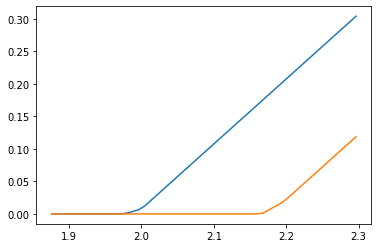

In [ ]:
#F^{(2)} at first stage
import numpy as np
import matplotlib.pyplot as plt

prob_first_stage = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]

v_bm_p = [[v_bm[s], prob_first_stage[s]] for s in range(S)]
v_bm_p.sort()

v_ssd_p = [[v_ssd[s], prob_first_stage[s]] for s in range(S)]
v_ssd_p.sort()

x_min = min(min([v_bm,v_ssd])) - 0.1
x_max = max(max([v_bm,v_ssd])) + 0.1
x_axis = np.linspace(x_min,x_max,50)

y_axis_bm = [sum(v_bm_p[s][1]*max(0,(x-v_bm_p[s][0])) for s in range(S)) for x in x_axis]

y_axis_ssd = [sum(v_ssd_p[s][1]*max(0,(x-v_ssd_p[s][0])) for s in range(S)) for x in x_axis]

plt.figure()
plt.plot(x_axis, y_axis_bm, color='tab:blue') #benchmark
plt.plot(x_axis, y_axis_ssd, color='tab:orange')

In [ ]:
v_bm,v_ssd, x_bm, x_ssd

([0.72, 0.72, 0.72],
 [0.7533917736278078, 0.7311509345550185, 0.72],
 [5.0, 0.0, 0.0],
 [4.099196689941724, 0.0, 0.9008033100582757])

In [ ]:
#m = gp.Model("m")
#x = m.addVar(vtype=GRB.CONTINUOUS, name="x", lb=0)
#y = m.addVar(vtype=GRB.CONTINUOUS, name="y", lb=0)
#m.setObjective(x-y, GRB.MINIMIZE)
#m.addConstr((x==1)>>(y-2*x<=0), name = "quad")
#m.addConstr((x==0)>>(y+x==0), name = "constant")
#m.optimize()

In [ ]:
a=[3+i for i in range(3)]
[a[i]*0.8 for i in range(len(a))]

[2.4000000000000004, 3.2, 4.0]

In [ ]:
def func(x):
    return x, x**2

(a,_) = func(2)
a

2

In [ ]:
ab = (np.ones(3)).tolist()
#ab = ab.tolist()
ab

[1.0, 1.0, 1.0]

In [ ]:
for i in range(0,3):
    print(i)

0
1
2
